In [21]:
import sys
import argparse
import csv
import math
import aubio
import numpy as np
import matplotlib.pyplot as plt

In [225]:
name = "nso"
filename = "../samples/%s.wav" % name

In [226]:
SAMPLE_RATE = 44100
WINDOW_SIZE = 4096 # fft size
HOP_SIZE = 1024
TOLERANCE = 0.8
METHOD = 'yinfft'

### Target Frequencies
The score, the clarinet runs from the G below Middle C to the C two octactives about. Because a clarinet is tuned to Bb, this is transposed down to F to Bb. In [modern tuning](https://en.wikipedia.org/wiki/Piano_key_frequencies), that's F3 (key #33) to Bb5 (key #62) on a piano, which is easy to calculate:

In [227]:
def getPianoFrequency(key_number):
    return np.power(2, (key_number-49) / 12) * 440

In [228]:
F3 = getPianoFrequency(33)
Bb5 = getPianoFrequency(62)
intermediateNotes = [ getPianoFrequency(f) for f in range(34,62) ]

In [229]:
pitches = []
s = aubio.source(filename, SAMPLE_RATE, HOP_SIZE)
pitch_o = aubio.pitch(METHOD, WINDOW_SIZE, HOP_SIZE, SAMPLE_RATE)
pitch_o.set_unit("Hz")
pitch_o.set_tolerance(TOLERANCE)
total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    pitches += [pitch]
    total_frames += read
    if read < HOP_SIZE: 
        print("read %s frames with method %s" % (total_frames, METHOD))
        break
        
# sometimes the first few pitches are off the charts        
while abs(pitches[0] - F3) > 50:
    pitches.pop(0)

read 242534 frames with method yinfft


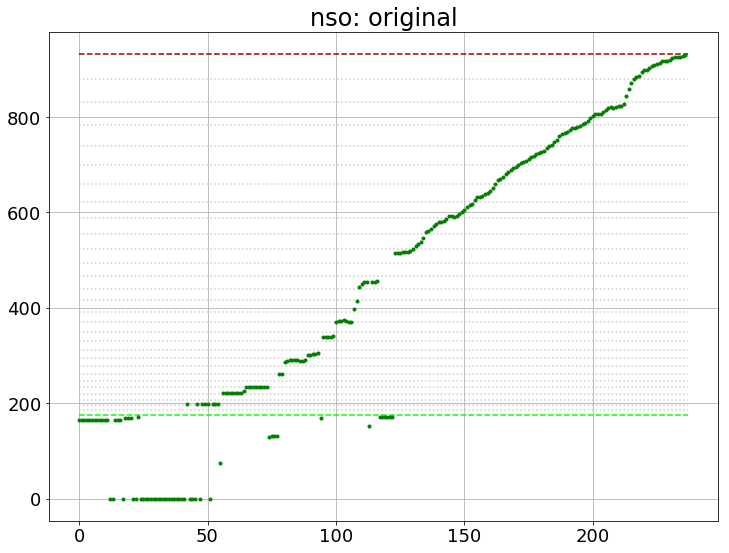

In [230]:
def plotFrequencies(pitch_group, name, chartName, write=False):
    pitch_group = np.array(pitch_group)
    fig = plt.figure(figsize=(12, 9), frameon=True)
    plt.title(name + ": " + chartName, fontsize=24)
    plt.hlines([F3, Bb5], xmin=0, xmax=len(pitch_group), linestyles="dashed", colors=["#00FF00", "#990000"])
    plt.hlines(intermediateNotes, xmin=0, xmax=len(pitch_group), linestyles="dotted", colors="#CCCCCC")
    ax = fig.gca()
    ax.tick_params(labelsize=18)
    ax.plot(list(range(len(pitch_group))), pitch_group, '.g', color="green")
    plt.grid()
    plt.show()
    if write:
        image_path = "../output/images/%s_%s.png" % (name, chartName)
        fig.savefig(image_path, pad_inches=1, dpi=300)
        
plotFrequencies(pitches, name, "original", True)

moving up note at 12 from 0.0 to 164.51105 (1.0)
moving up note at 13 from 0.0 to 164.51105 (1.0)
averaging 17 0.0 165.67743 1.0 166.803955078125
moving up note at 21 from 0.0 to 169.11647 (1.0)
averaging 22 0.0 169.11647 1.0 170.18609619140625
moving up note at 24 from 0.0 to 171.2557 (1.0)
moving up note at 25 from 0.0 to 171.2557 (1.0)
moving up note at 26 from 0.0 to 171.2557 (1.0)
moving up note at 27 from 0.0 to 171.2557 (1.0)
moving up note at 28 from 0.0 to 171.2557 (1.0)
moving up note at 29 from 0.0 to 171.2557 (1.0)
moving up note at 30 from 0.0 to 171.2557 (1.0)
moving up note at 31 from 0.0 to 171.2557 (1.0)
moving up note at 32 from 0.0 to 171.2557 (1.0)
moving up note at 33 from 0.0 to 171.2557 (1.0)
moving up note at 34 from 0.0 to 171.2557 (1.0)
moving up note at 35 from 0.0 to 171.2557 (1.0)
moving up note at 36 from 0.0 to 171.2557 (1.0)
moving up note at 37 from 0.0 to 171.2557 (1.0)
moving up note at 38 from 0.0 to 171.2557 (1.0)
moving up note at 39 from 0.0 to 17

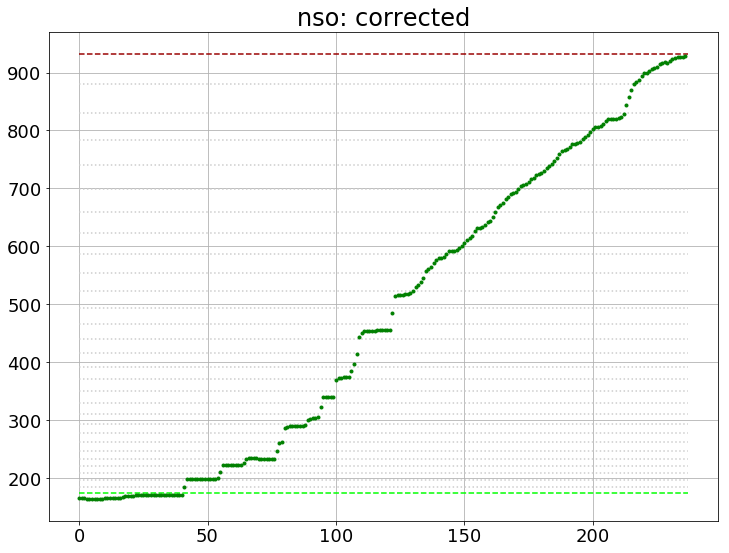

In [231]:
# first, identify all the outliers and move them closer to the correct position
corrected = pitches[:]
for i in range(1, len(corrected)):
    current = corrected[i]
    previous = corrected[i-1]
    diff = (previous - current) / previous
    
    if diff > 0.001:
        if (i < len(corrected) - 1 and (corrected[i+1] - previous) / previous > 0.01):
            average = (corrected[i-1] + corrected[i+1]) / 2
            print("averaging", i, current, previous, diff, average)
            corrected[i] = average
        else:
            print('moving up note at %s from %s to %s (%s)' % (i, current, previous, diff))                
            corrected[i] = previous

plotFrequencies(corrected.copy(), name, "corrected", True)

In [232]:
# then iterate over the corrected array, gradually bringing the outliers into line
smoothed = corrected.copy()
for x in range(2,20):
    arr = smoothed
    for i in range(1, len(arr)-1):
        diff = abs(arr[i] - arr[i+1]) / arr[i+1]
        threshold = 1 - 0.05 * x
        if diff > threshold:
            average = (arr[i-1] + arr[i+1]) / 2
            #print(x, i, threshold, arr[i], corrected[i-1], diff, average)
            smoothed[i] = average

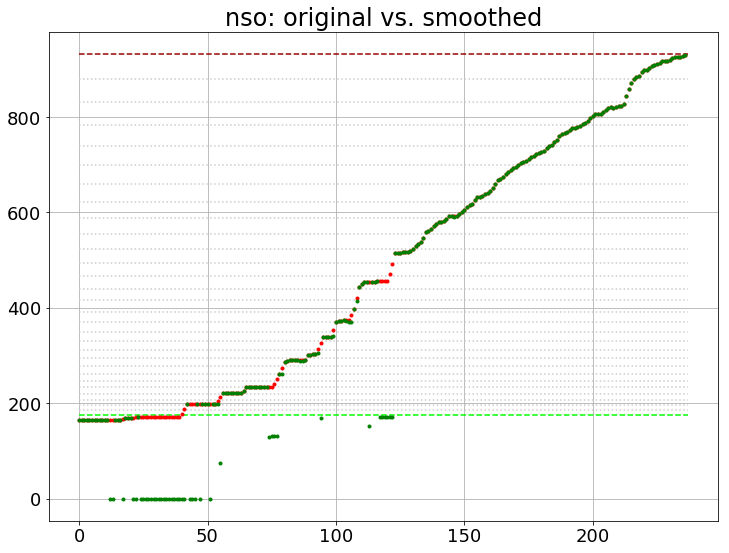

In [233]:
fig = plt.figure(figsize=(12, 9), frameon=True)
plt.title(name + ": " + "original vs. smoothed", fontsize=24)
plt.hlines([F3, Bb5], xmin=0, xmax=len(pitches), linestyles="dashed", colors=["#00FF00", "#990000"])
plt.hlines(intermediateNotes, xmin=0, xmax=len(pitches), linestyles="dotted", colors="#CCCCCC")
ax = fig.gca()
ax.tick_params(labelsize=18)
ax.plot(list(range(len(smoothed))), smoothed, '.g', color="red")
ax.plot(list(range(len(pitches))), pitches, '.g', color="green")
plt.grid()
plt.show()

image_path = "../output/images/%s_smoothed.png" % name
fig.savefig(image_path, pad_inches=1, dpi=300)

In [234]:
data_path = "../output/data/%s.csv" % name

with open(data_path, "w") as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(["freq"])    
    spamwriter.writerows(map(lambda x: [x], smoothed))